# Requirement 4 - BoBW algorithms with multiple products

# Setup


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import numpy as np
from scipy import optimize, stats
import heapq
import matplotlib.pyplot as plt
import itertools

## Environments

In [12]:
# Base Environment for the primal–dual pricing setup

class Environment:

    def __init__(self):
        self.sold = None

    def round(self, p_t):
        sold = (p_t <= self.valuations[self.t]).astype(int)

        if isinstance(self.cost, np.ndarray):
            cost_vec = self.cost.astype(float)
        else:
            cost_vec = np.full_like(p_t, float(self.cost), dtype=float)

        margin = np.maximum(p_t - cost_vec, 0.0)
        r_t = (margin * sold) / 100.0

        self.sold = sold
        self.rewards[self.t] = float(np.sum(r_t))
        self.t += 1
        return r_t

    def get_valuations(self):
        return self.valuations

    def plot_valuations(self, T, K):
        plt.figure(figsize=(10, 6))
        for k in range(K):
            plt.plot(range(T), self.valuations[:, k], marker='o', label=f'Item {k+1}')
        plt.xlabel('Round')
        plt.ylabel('Valuation')
        plt.title('Valuations Over Time')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend()
        plt.show()

In [13]:
# Stationary environment with valuations ~ Normal(50, var)

class StochasticEnvironment(Environment):

    def __init__(self, cost, var, T, N):
        self.valuations = (np.random.normal(loc=50, scale=var, size=(T, N)) % 100).astype(float)
        self.cost = float(cost) if np.isscalar(cost) else np.asarray(cost, dtype=float)
        self.rewards = np.zeros(T, dtype=float)
        self.t = 0


In [14]:
# Highly non-stationary environment with piecewise-random distributions.

class AdversarialEnvironment(Environment):

    def __init__(self, cost, T, N, min_step=2, max_step=100):
        self.valuations = np.zeros((T, N), dtype=float)
        self.cost = float(cost) if np.isscalar(cost) else np.asarray(cost, dtype=float)
        self.rewards = np.zeros(T, dtype=float)
        self.t = 0

        self.distributions = [
            "normal", "uniform", "laplace", "exponential",
            "triangular", "beta", "gamma", "binomial",
            "poisson", "chisquare", "lognormal", "weibull"
        ]

        t = 0
        rng = np.random.default_rng()
        while t < T:
            step = rng.integers(min_step, max_step + 1)
            if t + step > T:
                step = T - t

            dist = rng.choice(self.distributions)
            mean = rng.random() * 100
            var = rng.random() * 30 + 1

            for _ in range(step):
                if dist == "normal":
                    vals = rng.normal(mean, var, size=N)
                elif dist == "uniform":
                    vals = rng.uniform(0, 100, size=N)
                elif dist == "laplace":
                    vals = rng.laplace(mean, var, size=N)
                elif dist == "exponential":
                    vals = rng.exponential(scale=rng.random() * 20 + 1, size=N)
                elif dist == "triangular":
                    left, mode, right = 0.0, rng.random() * 100.0, 100.0
                    vals = rng.triangular(left, mode, right, size=N)
                elif dist == "beta":
                    a, b = rng.random() * 5 + 1, rng.random() * 5 + 1
                    vals = rng.beta(a, b, size=N) * 100
                elif dist == "gamma":
                    shape, scale = rng.random() * 5 + 1, rng.random() * 10 + 1
                    vals = rng.gamma(shape, scale, size=N)
                elif dist == "binomial":
                    n, p = int(rng.integers(5, 50)), rng.random()
                    vals = rng.binomial(n, p, size=N) * (100.0 / n)
                elif dist == "poisson":
                    lam = rng.random() * 20 + 1
                    vals = rng.poisson(lam, size=N) * 5.0
                elif dist == "chisquare":
                    df = rng.random() * 10 + 1
                    vals = rng.chisquare(df, size=N) * 5.0
                elif dist == "lognormal":
                    mu, sigma = rng.random() * 3, rng.random() * 1.5 + 0.1
                    vals = rng.lognormal(mu, sigma, size=N)
                elif dist == "weibull":
                    a = rng.random() * 5 + 0.5
                    vals = rng.weibull(a, size=N) * 20.0
                else:
                    vals = rng.uniform(0, 100, size=N)

                # Wrap to [0,100)
                self.valuations[t] = np.mod(np.round(vals), 100.0)
                t += 1


## Agents

In [15]:
# Primal–dual allocator: solve max_γ ⟨f,γ⟩ s.t. ⟨c,γ⟩ ≤ ρ and per-item simplex (incl. skip).
# Uses Lagrangian best-response per item (argmax f−λc, uniform tie-split) and bisection on λ
# to meet the capacity ρ (within tol). Returns γ shape (N, P+1) with column 0 = skip.

class Agent:

    def __init__(self):
        pass

    def pull_arm(self, *args, **kwargs):
        raise NotImplementedError

    def update(self, r_t, sold):
        raise NotImplementedError

    def compute_opt(self, f_ucbs, c_lcbs, rho, *, tol=1e-9, max_iter=60, tie_bias_to_sell=False):

        N, P = self.N, self.K
        f_ucbs = np.asarray(f_ucbs, dtype=float).reshape(N, P)
        c_lcbs = np.asarray(c_lcbs, dtype=float).reshape(N, P)

        f = np.hstack([np.zeros((N, 1)), f_ucbs])
        c = np.hstack([np.zeros((N, 1)), c_lcbs])

        if tie_bias_to_sell:
            f[:, 1:] += 1e-12

        if rho <= 0:
            gamma = np.zeros((N, P + 1), dtype=float)
            gamma[:, 0] = 1.0
            return gamma

        def best_response(lmbda):
            scores = f - lmbda * c
            rowmax = np.max(scores, axis=1, keepdims=True)
            ties = np.abs(scores - rowmax) <= 1e-12
            counts = np.sum(ties, axis=1, keepdims=True)
            gamma_local = ties.astype(float) / counts
            total_cons = float(np.sum(c * gamma_local))
            return gamma_local, total_cons

        lam_lo, lam_hi = 0.0, 1.0
        _, cons_lo = best_response(lam_lo)
        if cons_lo <= rho + tol:
            return best_response(lam_lo)[0]

        for _ in range(40):
            _, cons_hi = best_response(lam_hi)
            if cons_hi <= rho + tol:
                break
            lam_hi *= 2.0
        else:
            gamma = np.zeros((N, P + 1), dtype=float)
            gamma[:, 0] = 1.0
            return gamma

        for _ in range(max_iter):
            lam_mid = 0.5 * (lam_lo + lam_hi)
            _, cons_mid = best_response(lam_mid)
            if cons_mid > rho + tol:
                lam_lo = lam_mid
            else:
                lam_hi = lam_mid
            if abs(lam_hi - lam_lo) <= 1e-9:
                break

        return best_response(lam_hi)[0]


In [16]:
# UCB1Agent: stochastic bandit over K prices for N items.
# pull_arm(B): compute reward UCBs and sell-rate LCBs, enforce capacity via compute_opt,
# then sample {skip, price}; 101 = skip (warm-start cycles arms).
# update(r_t, sold): update counts and incremental mean rewards for chosen arms;
# track sales and cumulative reward.

class UCB1Agent(Agent):

    def __init__(self, T, N, price_set=None):
        self.N = int(N)
        self.T = int(T)

        if price_set is None:
            self.price_set = np.array([0, 20, 40, 60, 80, 100], dtype=np.float32)
        else:
            self.price_set = np.array(price_set, dtype=np.float32)

        self.K = len(self.price_set)
        self.a_t = np.ones(self.N, dtype=int) * -1
        self.t = 0

        self.average_rewards = np.zeros((self.N, self.K), dtype=float)
        self.N_pulls        = np.zeros((self.N, self.K), dtype=int)
        self.sales_counter  = np.zeros((self.N, self.K), dtype=float)

        self.rewards = np.zeros(self.T, dtype=float)
        self._eps = 1e-12

        self.last_gamma = None
        self.last_c_lcbs = None
        self.last_rho = None

    def pull_arm(self, B):
        if self.t < self.K:
            self.a_t[:] = self.t
            return self.price_set[self.a_t].astype(np.float32)

        if B < self.N:
            self.a_t[:] = -1
            return np.ones(self.N, dtype=np.float32) * 101.0

        avg_c = np.divide(
            self.sales_counter,
            np.maximum(self.N_pulls, 1),
            out=np.zeros_like(self.sales_counter, dtype=float),
            where=(np.maximum(self.N_pulls, 1) > 0)
        )

        pulls_safe = np.maximum(self.N_pulls, 1)
        bonus = np.sqrt(2.0 * np.log(max(2, self.T)) / pulls_safe)
        f_ucbs = self.average_rewards + bonus

        c_lcbs = np.clip(avg_c - bonus, 0.0, 1.0)

        rho = B / max(1, (self.T - self.t))

        gamma = self.compute_opt(f_ucbs, c_lcbs, rho)
        self.last_gamma = gamma
        self.last_c_lcbs = c_lcbs
        self.last_rho = rho

        prices = np.empty(self.N, dtype=np.float32)
        for i in range(self.N):
            probs = gamma[i].astype(float)
            probs[probs < 0] = 0.0
            s = probs.sum()
            if not np.isfinite(s) or s <= 0:
                probs = np.zeros_like(probs); probs[0] = 1.0
            else:
                probs /= s

            choice = np.random.choice(self.K + 1, p=probs)
            self.a_t[i] = choice - 1
            prices[i] = 101.0 if self.a_t[i] < 0 else self.price_set[self.a_t[i]]

        return prices

    def update(self, r_t, sold):

        self.rewards[self.t] = float(np.sum(r_t))
        self.t += 1

        for i in range(self.N):
            arm = int(self.a_t[i])
            if arm >= 0:
                self.N_pulls[i, arm] += 1
                self.sales_counter[i, arm] += float(sold[i])

                n = self.N_pulls[i, arm]
                prev = self.average_rewards[i, arm]
                self.average_rewards[i, arm] = prev + (float(r_t[i]) - prev) / n

In [17]:
# EXP3Agent: adversarial bandit over K prices for N items.
# pull_arm(B): form per-item probs from weights (with floor/exploration, LCB/optimism),
# solve capacity via compute_opt, sample {skip, price}; 101 = skip.
# update(r_t, sold): importance-weighted feedback, EXP3 weight update (multiplicative),
# update counts/averages and cumulative reward.

class EXP3Agent(Agent):

    def __init__(
        self,
        T, N,
        price_set=None,
        p_floor=0.05,
        gamma_explore=0.05,
        warm_start_rounds=None,
        use_c_lcb=True,
        optimism=0.0
    ):
        self.N = int(N)
        self.T = int(T)

        if price_set is None:
            self.price_set = np.array([0, 20, 40, 60, 80, 100], dtype=np.float32)
        else:
            self.price_set = np.array(price_set, dtype=np.float32)

        self.K = len(self.price_set)
        self.a_t = np.ones(self.N, dtype=int) * -1
        self.t = 0

        self.learning_rate = np.sqrt(np.log(max(2, self.K)) / (self.K * max(1, self.T)))

        self.weights = np.ones((self.N, self.K), dtype=np.float64)
        self.N_pulls = np.zeros((self.N, self.K), dtype=int)
        self.p_t = np.ones((self.N, self.K), dtype=np.float64) / self.K
        self.sales_counter = np.zeros((self.N, self.K), dtype=float)

        self.rewards = np.zeros(self.T, dtype=float)
        self.sampled_prob = np.zeros(self.N, dtype=float)
        self._eps = 1e-12

        self.reward_sum_hat = np.zeros((self.N, self.K), dtype=float)
        self.count_hat      = np.zeros((self.N, self.K), dtype=float)
        self.avg_reward_hat = np.zeros((self.N, self.K), dtype=float)

        self.last_policy = None
        self.last_weights = None
        self.last_prices = None

        self._p_floor = float(p_floor)
        self._gamma_explore = float(gamma_explore)
        self._warm_start_rounds = int(2 * self.K) if warm_start_rounds is None else int(warm_start_rounds)
        self._use_c_lcb = bool(use_c_lcb)
        self._optimism = float(optimism)

    def pull_arm(self, B):
        if B < self.N:
            self.a_t[:] = -1
            self.sampled_prob[:] = 1.0
            return np.ones(self.N, dtype=np.float32) * 101.0

        if self.t < self._warm_start_rounds:
            arm = self.t % self.K
            self.a_t[:] = arm
            return self.price_set[self.a_t].astype(np.float32)

        prices = np.zeros(self.N, dtype=np.float32)
        rho = B / max(1, self.T - self.t)

        denom = np.clip(self.weights.sum(axis=1, keepdims=True), self._eps, None)
        p = self.weights / denom
        if self._p_floor > 0.0:
            p = (1.0 - self._p_floor) * p + self._p_floor / self.K
        self.p_t = p

        self.last_policy = self.p_t.copy()
        self.last_weights = self.weights.copy()

        avg_c = np.divide(
            self.sales_counter,
            np.maximum(self.N_pulls, 1),
            out=np.zeros_like(self.sales_counter, dtype=float),
            where=(np.maximum(self.N_pulls, 1) > 0)
        )

        c_lcbs = avg_c
        if self._use_c_lcb:
            pulls_safe = np.maximum(self.N_pulls, 1)
            c_bonus = np.sqrt(2.0 * np.log(max(2, self.T)) / pulls_safe)
            c_lcbs = np.clip(avg_c - c_bonus, 0.0, 1.0)

        r_counts = np.maximum(self.count_hat, 1.0)
        optimism_term = self._optimism * np.sqrt(2.0 * np.log(max(2, self.T)) / r_counts)
        f_ucbs = self.avg_reward_hat + optimism_term

        gamma = self.compute_opt(f_ucbs, c_lcbs, rho, tie_bias_to_sell=True)

        if self._gamma_explore > 0.0:
            uniform_sell = np.zeros(self.K + 1); uniform_sell[1:] = 1.0 / self.K
            beta = self._gamma_explore
            gamma = (1.0 - beta) * gamma + beta * uniform_sell[None, :]

        self.sampled_prob[:] = 0.0
        for n in range(self.N):
            probs = np.asarray(gamma[n], dtype=float)
            probs[probs < 0] = 0.0
            s = probs.sum()
            if not np.isfinite(s) or s <= 0:
                probs = np.zeros_like(probs); probs[0] = 1.0
            else:
                probs = probs / s

            choice = np.random.choice(len(probs), p=probs)
            self.sampled_prob[n] = float(probs[choice])
            price_idx = choice - 1
            self.a_t[n] = price_idx
            prices[n] = 101.0 if price_idx < 0 else self.price_set[price_idx]

        self.last_prices = prices.copy()
        return prices

    def update(self, r_t, sold):

        self.rewards[self.t] = float(np.sum(r_t))
        self.t += 1

        for i in range(self.N):
            arm = int(self.a_t[i])
            if arm >= 0:
                self.N_pulls[i, arm] += 1
                self.sales_counter[i, arm] += float(sold[i])

                prob_played = float(max(1e-9, self.sampled_prob[i]))
                r_i = float(np.clip(r_t[i], 0.0, 1.0))
                iw_reward = r_i / prob_played
                self.reward_sum_hat[i, arm] += iw_reward
                self.count_hat[i, arm] += 1.0
                self.avg_reward_hat[i, arm] = (
                    self.reward_sum_hat[i, arm] / max(1.0, self.count_hat[i, arm])
                )

                loss_hat = (1.0 - r_i) / prob_played
                self.weights[i, arm] *= np.exp(-self.learning_rate * loss_hat)

## Coordinators

In [18]:
# Coordinator: meta-policy over multiple base agents.
# - choose_agent(): pick which agent acts this round (to be implemented).
# - run(env, B): for t=0..T-1, call chosen_agent.pull_arm(B), play in env,
#   decrement budget by units sold, log inventory/reward, call agent.update(...)
#   and coordinator.update(...). Tracks pulls per agent and final remaining budget.

class Coordinator:
    def __init__(self, T, N, agents):
        self.T = int(T)
        self.N = int(N)
        self.agents = list(agents)

        M = len(self.agents)
        self.N_pulls = np.zeros(M, dtype=int)
        self.rewards = np.zeros(self.T, dtype=float)
        self.log_inventory = np.zeros(self.T, dtype=int)
        self.t = 0

        self._last_chosen = None
        self._last_probs = None

    def choose_agent(self):
        raise NotImplementedError

    def update(self, chosen_agent_index, reward_vector):
        raise NotImplementedError

    def run(self, env, B):
        B = int(B)
        for t in range(self.T):
            self.t = t
            agent, idx = self.choose_agent()
            self.N_pulls[idx] += 1

            p = agent.pull_arm(B)
            r_t = env.round(p)
            sold = np.asarray(env.sold, dtype=int)
            B -= int(sold.sum())
            if B < 0:
                B = 0

            self.log_inventory[t] = B
            self.rewards[t] = float(np.sum(r_t))
            agent.update(r_t, sold)
            self.update(idx, r_t)

        self.final_budget = B

In [19]:
# UCB1Coordinator: treats base agents (UCB1, EXP3) as arms.
# Warm-up: one round per agent; then select agent with highest UCB
#   UCB_i = (total_rewards_i / pulls_i) + sqrt(2 ln(t+1) / pulls_i).
# run() calls the chosen agent, logs reward/inventory; update() accumulates rewards.

class UCB1Coordinator(Coordinator):
    def __init__(self, T, N):
        super().__init__(T, N, agents=[UCB1Agent(T, N), EXP3Agent(T, N)])
        self.total_rewards = np.zeros(len(self.agents), dtype=float)
        self._warmup_done = False

    def choose_agent(self):
        M = len(self.agents)
        if self.N_pulls.sum() < M:
            idx = int(self.N_pulls.sum())
            self._last_probs = None
            self._last_chosen = idx
            return self.agents[idx], idx

        pulls = np.maximum(self.N_pulls, 1)
        avg = self.total_rewards / pulls
        bonus = np.sqrt(2.0 * np.log(max(2, self.t + 1)) / pulls)
        ucbs = avg + bonus
        idx = int(np.argmax(ucbs))
        self._last_probs = None
        self._last_chosen = idx
        return self.agents[idx], idx

    def update(self, chosen_agent_index, reward_vector):
        self.total_rewards[chosen_agent_index] += float(np.sum(reward_vector))

In [20]:
# EXP3Coordinator: meta-EXP3 over base agents (UCB1, EXP3).
# choose_agent(): sample agent i from weights-mixed probs with exploration γ.
# update(): normalize reward, do importance-weighted loss, multiplicative weight update (η=√(log M/(M·T))).

class EXP3Coordinator(Coordinator):
    def __init__(self, T, N, gamma=0.05):
        super().__init__(T, N, agents=[UCB1Agent(T, N), EXP3Agent(T, N)])
        self.M = len(self.agents)
        self.gamma = float(gamma)
        self.weights = np.ones(self.M, dtype=float)
        self.learning_rate = np.sqrt(np.log(self.M) / (self.M * max(1, self.T)))

    def _meta_probs(self):
        w = self.weights / np.sum(self.weights)
        probs = (1.0 - self.gamma) * w + self.gamma * (1.0 / self.M)
        probs = np.clip(probs, 1e-12, 1.0)
        probs = probs / probs.sum()
        return probs

    def choose_agent(self):
        probs = self._meta_probs()
        idx = int(np.random.choice(self.M, p=probs))
        self._last_probs = probs
        self._last_chosen = idx
        return self.agents[idx], idx

    def update(self, chosen_agent_index, reward_vector):
        r_sum = float(np.sum(reward_vector))
        r_norm = np.clip(r_sum / max(1, self.N), 0.0, 1.0)

        probs = self._last_probs if self._last_probs is not None else self._meta_probs()
        p_i = float(max(1e-12, probs[chosen_agent_index]))
        loss_hat = (1.0 - r_norm) / p_i

        self.weights[chosen_agent_index] *= np.exp(-self.learning_rate * loss_hat)

## Utils

In [42]:
# compute_regret(...): builds the above oracle along the agent’s inventory path, computes
# oracle_cum and agent_cum, and returns per-item regret curve ( (oracle−agent)/N ), plus both cumulatives.

def compute_regret(env, B0, T, N, rewards, inventory, price_set):

    rewards = np.asarray(rewards, dtype=float)
    agent_cum = np.cumsum(rewards)

    cost = env.cost
    if np.isscalar(cost):
        cost_vec = np.full(N, float(cost), dtype=float)
    else:
        cost_vec = np.asarray(cost, dtype=float)

    oracle = PrefixOracleTracker(B0=B0, T=T, price_set=price_set, cost_vec=cost_vec, N=N)
    oracle_cum = np.zeros(T, dtype=float)

    used_series = B0 - np.asarray(inventory, dtype=int)
    for t in range(T):
        k_t = int(min(B0, used_series[t]))
        oracle.step(t, env.valuations[t], k_t)
        oracle_cum[t] = oracle.oracle_cum

    regret_curve = (oracle_cum - agent_cum) / N # regret is normalized for ease of analysis
    return regret_curve, oracle_cum, agent_cum

In [56]:
def show_results_plot(T, K, regret, agent_cum, oracle_cum, log_inventory, coord_type, env_type):
    K = len(price_set)
    t_values = np.arange(1, T+1)

    if env_type == "Stochastic":
        bound = np.sqrt(K * np.log(t_values) * t_values)
    else:
        bound = np.sqrt(K * np.log(max(2, K)) * t_values)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(t_values, regret, label='Regret vs synced oracle')
    plt.plot(t_values, agent_cum, label='Agent cumulative', alpha=0.7)
    plt.plot(t_values, oracle_cum, label='Oracle cumulative', linestyle='--', alpha=0.8)
    plt.plot(t_values, log_inventory, label='Inventory (remaining)', color='green', alpha=0.6)
    plt.xlabel('Round'); plt.ylabel('Value'); plt.title(f"{coord_type}-coordinator in {env_type} Environment")

    if env_type == "Stochastic":
        plt.plot(t_values, bound, linestyle="--", alpha=0.4, label="√(K t log t) (ref)")
    else:
        plt.plot(t_values, bound, linestyle="--", alpha=0.4, label="√(K t log K) (ref)")

    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(t_values, regret / t_values, label='R(t)/t', color='red')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel('Round'); plt.ylabel('Regret per round'); plt.title('Normalized R(t)/t')
    plt.legend(); plt.grid(True)

    plt.tight_layout(); plt.show()
    print("Coordinator pulls per base agent:", coord.N_pulls.astype(int))

# Empirical study

## Stochastic setting
We test two meta-coordinators in a stochastic environment with one item:
UCB1Coordinator: selects between UCB1 and EXP3 agents using a UCB rule over their past rewards.
EXP3Coordinator: treats UCB1 and EXP3 as arms of an EXP3 meta-bandit, sampling agents via exponential weights.
In both cases, we track regret vs. theoretical bounds and check for sublinear growth.

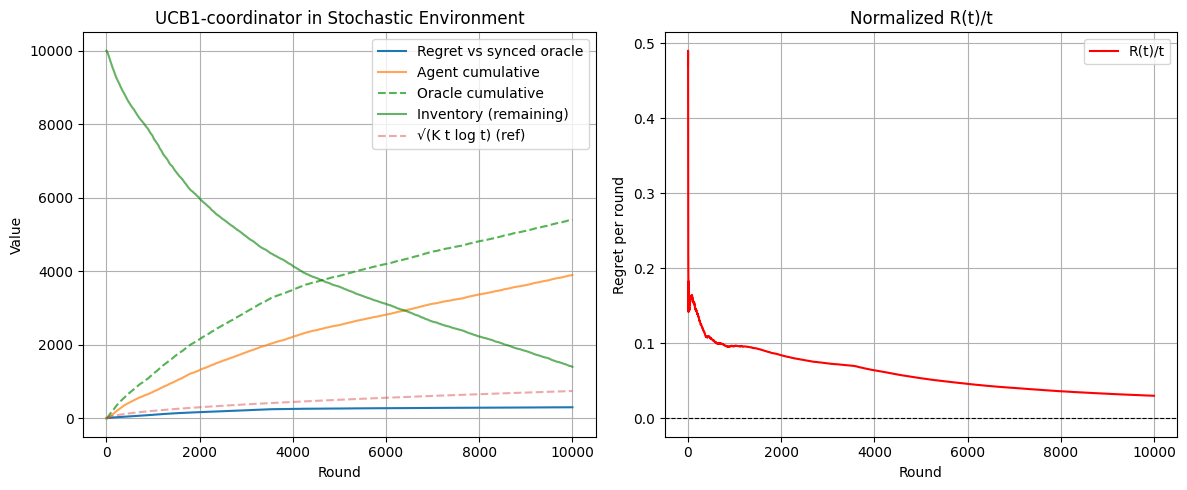

Coordinator pulls per base agent: [5674 4326]


In [64]:
# UCB1 Coordinator test in Stochastic Environment
T = 10_000
N = 5
B0 = int(T/5 * N)

np.random.seed(42)

coord = UCB1Coordinator(T, N)
env = StochasticEnvironment(cost=5, var=20, T=T, N=N)

coord.run(env, B0)

price_set = coord.agents[0].price_set if hasattr(coord.agents[0], "price_set") else np.array([0,20,40,60,80,100])
regret, oracle_cum, agent_cum = compute_regret(
    env=env,
    B0=B0, T=T, N=N,
    rewards=coord.rewards,
    inventory=coord.log_inventory,
    price_set=price_set
)

show_results_plot(T, K, regret, agent_cum, oracle_cum, coord.log_inventory, "UCB1", "Stochastic")

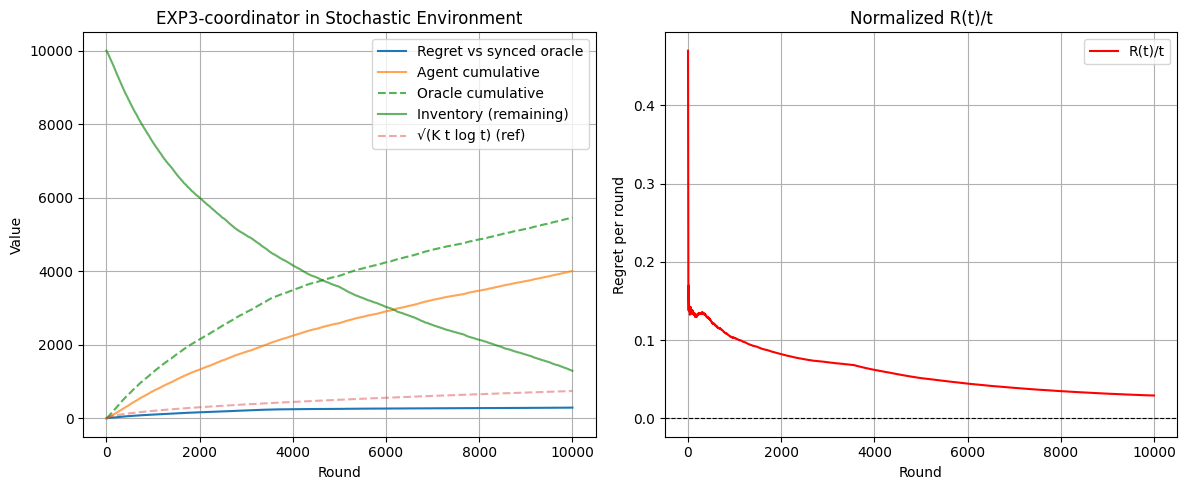

Coordinator pulls per base agent: [6270 3730]


In [63]:
# UCB1 Coordinator test in Stochastic Environment
T = 10_000
N = 5
B0 = int(T/5 * N)

np.random.seed(42)

coord = EXP3Coordinator(T, N)
env = StochasticEnvironment(cost=5, var=20, T=T, N=N)

coord.run(env, B0)

price_set = coord.agents[0].price_set if hasattr(coord.agents[0], "price_set") else np.array([0,20,40,60,80,100])
regret, oracle_cum, agent_cum = compute_regret(
    env=env,
    B0=B0, T=T, N=N,
    rewards=coord.rewards,
    inventory=coord.log_inventory,
    price_set=price_set
)

show_results_plot(T, K, regret, agent_cum, oracle_cum, coord.log_inventory, "EXP3", "Stochastic")

## Adversarial setting
Adversarial tests for meta-coordinators.
UCB1Coordinator, N=5: runs in a WildAdversarialEnvironment, selecting between UCB1/EXP3 via UCB over agents; we plot regret vs. √(K·t·log K) and inventory, then fit
R
(
t
)
≈
C
t
α
R(t)≈Ct
α
  to check sublinearity.
EXP3Coordinator, N=1: same adversarial setting but coordination via EXP3 exponential weights; we compare regret to the same bound and assess the fitted exponent
α
<
1
α<1

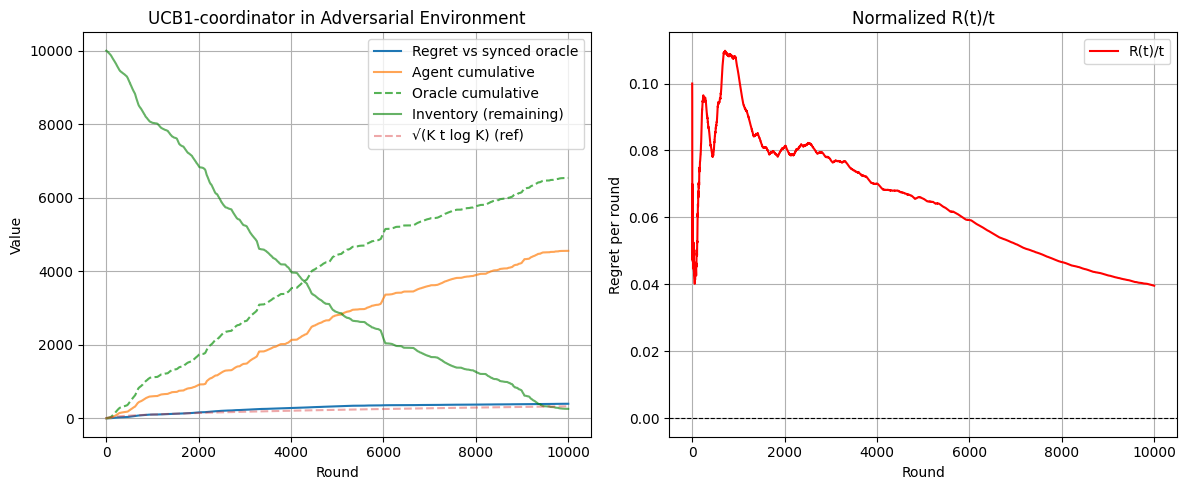

Coordinator pulls per base agent: [6938 3062]


In [61]:
# UCB1 Coordinator test in Stochastic Environment
T = 10_000
N = 5
B0 = int(T/5 * N)

np.random.seed(42)

coord = UCB1Coordinator(T, N)
env   = AdversarialEnvironment(cost=5, T=T, N=N)

coord.run(env, B0)

price_set = coord.agents[0].price_set if hasattr(coord.agents[0], "price_set") else np.array([0,20,40,60,80,100])
regret, oracle_cum, agent_cum = compute_regret(
    env=env,
    B0=B0, T=T, N=N,
    rewards=coord.rewards,
    inventory=coord.log_inventory,
    price_set=price_set
)

show_results_plot(T, K, regret, agent_cum, oracle_cum, coord.log_inventory, "UCB1", "Adversarial")

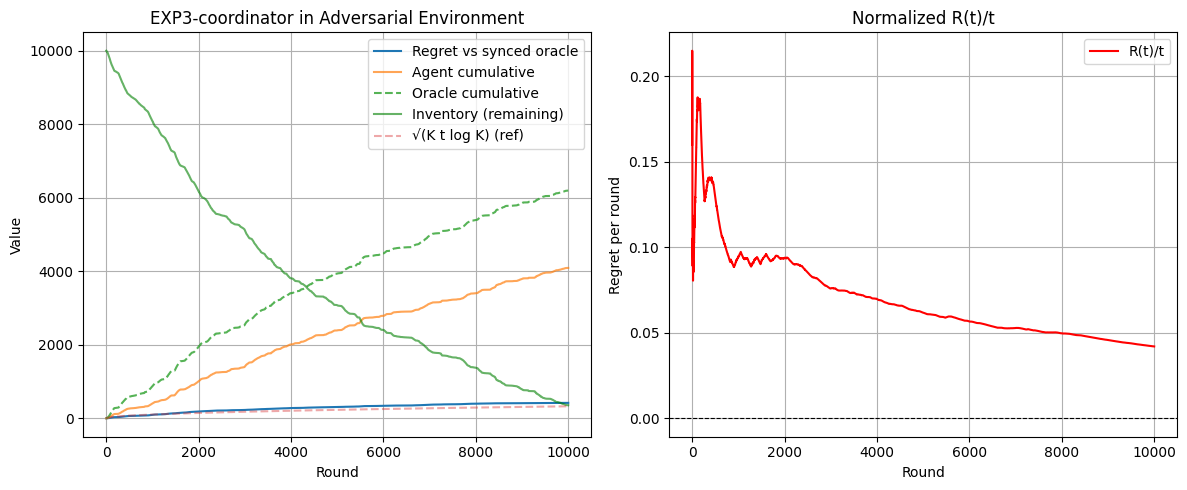

Coordinator pulls per base agent: [5999 4001]


In [62]:
# UCB1 Coordinator test in Stochastic Environment
T = 10_000
N = 5
B0 = int(T/5 * N)

np.random.seed(42)

coord = EXP3Coordinator(T, N)
env   = AdversarialEnvironment(cost=5, T=T, N=N)

coord.run(env, B0)

price_set = coord.agents[0].price_set if hasattr(coord.agents[0], "price_set") else np.array([0,20,40,60,80,100])
regret, oracle_cum, agent_cum = compute_regret(
    env=env,
    B0=B0, T=T, N=N,
    rewards=coord.rewards,
    inventory=coord.log_inventory,
    price_set=price_set
)

show_results_plot(T, K, regret, agent_cum, oracle_cum, coord.log_inventory, "EXP3", "Adversarial")